# Produce Cached `galaxy_ids` for DC2

_Last Updated: Bryce Kalmbach, September 2018_

This is a notebook to produce the cached AGN and SN galaxy_id lists for DC2 Run 2. In this notebook we match the source AGN and SNe galaxies to objects in the galaxy catalogs.

In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
from desc.sims.GCRCatSimInterface import InstanceCatalogWriter
from lsst.sims.utils import SpecMap
import matplotlib.pyplot as plt
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass
from lsst.sims.catUtils.matchSED import matchBase
import os
import sqlite3
%matplotlib inline

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catalogs/2.9.0.sims/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 4 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/global/common/software/lsst/cori-haswell-gcc/stack/w.2018.26_sim2.9.0/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_catalogs/2.9.0.sims/python/lsst/sims/catalogs/db/dbConnection.py:553: UserWarning: Duplicate object type id 28 specified: 
Out

## Point to locations for unlensed AGN and SNe information

Even if you already have an unsprinkled instance catalog ready you need to specify the locations of DC2 unlensed AGN and SNe databases. The AGN database is needed to know the AGN properties to sprinkle and the SNe database is needed to avoid sprinkling with galaxies that will have unlensed SNe at some point in the survey.

In [2]:
agnDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_db_mbh7_mi30_sf4.db'
sneDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sne_cosmoDC2_v1.1.4_MS_DDF.db'
assert os.path.isfile(agnDB)
assert os.path.isfile(sneDB)

### Create an unsprinkled Instance Catalog 

This is to get the possible AGN and Bulge galaxies to replace with the sprinkler. We use `cosmoDC2_v1.1.0_addon_knots`. Make sure to specify the correct database locations in the cell below.

In [ ]:
# First we need to create a catalog without sprinkling
opsimDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/minion_1016_desc_dithered_v4.db'
starDB = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/dc2_stellar_db.db'

In [6]:
t_sky = InstanceCatalogWriter(opsimDB, 'cosmoDC2_v1.1.4_image_addon_knots', min_mag=30, protoDC2_ra=0,
                              protoDC2_dec=0, sprinkler=False,
                              agn_db_name=agnDB, star_db_name=starDB,
                              sed_lookup_dir='/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup')

In [7]:
uddf_visit = 197356 # Use a visit we know covers the uDDF field
t_sky.write_catalog(uddf_visit, out_dir='.', fov=1.5)

writing stars
writing knots


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCR/composite.py:110: UserWarning: CompositeCatalog is still an experimental feature. Use with care!
  warnings.warn('CompositeCatalog is still an experimental feature. Use with care!')


loading the catalog took 1.334465e-02 hrs
Using the DESCQAChunkIterator_healpix class
pre shuffle  [8787 8914 8915 9043]
post shuffle  [8914 8915 8787 9043]

loading healpix 9043
    loading hp: 9043; 0 -> 6388325
starting cache; 1.2e+00 Gb
caching  [9043] disk r
keeping 8929260 of 17182059
ending cache; 1.8e+00 Gb
    loading hp: 9043; 6388330 -> 17182048

loading healpix 8787
    loading hp: 8787; 63 -> 17234605
starting cache; 1.1e+00 Gb
caching  [8787] disk r
keeping 2739796 of 17234862
ending cache; 1.4e+00 Gb

loading healpix 8915
    loading hp: 8915; 4 -> 14898905
starting cache; 1.3e+00 Gb
caching  [8915] disk r
keeping 6092671 of 17215541
ending cache; 1.7e+00 Gb
    loading hp: 8915; 14898928 -> 17215520

loading healpix 8914
    loading hp: 8914; 0 -> 17251360
starting cache; 1.1e+00 Gb
caching  [8914] disk r
keeping 5377355 of 17251417
ending cache; 1.6e+00 Gb
writing bulges
Using the DESCQAChunkIterator_healpix class
pre shuffle  [8787 8914 8915 9043]
post shuffle  [8914 

### Load in the galaxy catalogs as dataframes

In [3]:
base_columns = ['prefix', 'uniqueId', 'raPhoSim', 'decPhoSim',
                        'phosimMagNorm', 'sedFilepath', 'redshift',
                        'shear1', 'shear2', 'kappa', 'raOffset', 'decOffset',
                        'spatialmodel']

In [4]:
df_galaxy = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'bulge_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [5]:
df_disk = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'disk_gal_cat_197356.txt.gz'),
                                delimiter=' ', header=None,
                                names=base_columns+['majorAxis', 'minorAxis',
                                                    'positionAngle', 'sindex',
                                                    'internalExtinctionModel',
                                                    'internalAv', 'internalRv',
                                                    'galacticExtinctionModel',
                                                    'galacticAv', 'galacticRv'])

In [125]:
df_agn = pd.read_csv(os.path.join(os.environ['SCRATCH'],
                                     'agn_gal_cat_197356.txt.gz'),
                                 delimiter=' ', header=None,
                                 names=base_columns+['internalExtinctionModel',
                                                     'galacticExtinctionModel',
                                                     'galacticAv', 'galacticRv'])

We calculate the `galaxy_id` for each catalog so that we can join them together and also save it in the cache for the sprinkler.

In [126]:
df_agn['galaxy_id'] = np.right_shift(df_agn['uniqueId'], 10)

In [127]:
df_agn.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,raOffset,decOffset,spatialmodel,internalExtinctionModel,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,2624000071797,53.349798,-28.554964,22.705837,agnSED/agn.spec.gz,0.047118,0.000005,0.000002,-0.000014,0,0,point,none,CCM,0.020457,3.1,2562500070
1,object,2624000083061,53.833428,-27.997008,23.011965,agnSED/agn.spec.gz,0.047681,-0.000008,-0.000018,-0.000026,0,0,point,none,CCM,0.030825,3.1,2562500081
2,object,2624000093301,52.522117,-28.319685,24.403659,agnSED/agn.spec.gz,0.048877,-0.000004,-0.000012,-0.000019,0,0,point,none,CCM,0.026697,3.1,2562500091
3,object,2624000120949,53.993377,-28.493004,20.841246,agnSED/agn.spec.gz,0.044360,-0.000014,0.000010,-0.000026,0,0,point,none,CCM,0.034091,3.1,2562500118
4,object,2624000216181,54.208142,-28.425526,22.778801,agnSED/agn.spec.gz,0.042932,-0.000003,0.000003,-0.000019,0,0,point,none,CCM,0.031863,3.1,2562500211


In [9]:
df_galaxy['galaxy_id'] = np.right_shift(df_galaxy['uniqueId'], 10)

In [10]:
df_galaxy.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,2624000015457,54.128901,-28.112305,20.729031,galaxySED/Inst.62E09.02Z.spec.gz,0.020068,-0.0,-0.0,0.0,...,0.820732,119.560977,4,CCM,0.0,2.0,CCM,0.032702,3.1,2562500015
1,object,2624000020577,53.493264,-27.925766,21.189665,galaxySED/Inst.25E09.02Z.spec.gz,0.021270,-0.0,-0.0,0.0,...,0.618218,95.434331,4,CCM,0.0,2.0,CCM,0.021368,3.1,2562500020
2,object,2624000026721,52.925348,-28.628385,21.910570,galaxySED/Exp.80E09.02Z.spec.gz,0.019366,-0.0,-0.0,0.0,...,0.325353,29.593816,4,CCM,0.0,2.0,CCM,0.030184,3.1,2562500026
3,object,2624000030817,53.387651,-27.752752,20.989436,galaxySED/Inst.40E09.0005Z.spec.gz,0.017884,-0.0,-0.0,0.0,...,0.440540,28.999509,4,CCM,0.0,2.0,CCM,0.022445,3.1,2562500030
4,object,2624000034913,53.329267,-28.122075,21.725222,galaxySED/Inst.32E09.0005Z.spec.gz,0.022079,-0.0,-0.0,0.0,...,0.411478,151.776670,4,CCM,0.0,2.0,CCM,0.026089,3.1,2562500034


In [75]:
df_disk['galaxy_id'] = np.right_shift(df_disk['uniqueId'], 10)

In [76]:
df_disk.head()

,prefix,uniqueId,raPhoSim,decPhoSim,phosimMagNorm,sedFilepath,redshift,shear1,shear2,kappa,...,minorAxis,positionAngle,sindex,internalExtinctionModel,internalAv,internalRv,galacticExtinctionModel,galacticAv,galacticRv,galaxy_id
0,object,2624000000107,52.858186,-27.842471,17.868629,galaxySED/Burst.50E09.0005Z.spec.gz,0.022208,-0.0,-0.0,0.0,...,1.298832,169.290615,1,CCM,0.1,2.8,CCM,0.023106,3.1,2562500000
1,object,2624000006251,52.992274,-28.605817,21.256434,galaxySED/Burst.20E09.0005Z.spec.gz,0.021026,-0.0,-0.0,0.0,...,0.835587,67.781191,1,CCM,0.1,3.4,CCM,0.028443,3.1,2562500006
2,object,2624000007275,52.625511,-28.261916,18.804901,galaxySED/Exp.16E09.02Z.spec.gz,0.017854,-0.0,-0.0,0.0,...,4.781946,4.371048,1,CCM,0.1,4.0,CCM,0.024487,3.1,2562500007
3,object,2624000008299,53.748818,-28.632551,20.638686,galaxySED/Burst.20E09.0005Z.spec.gz,0.017479,-0.0,-0.0,0.0,...,2.454897,92.899542,1,CCM,0.1,2.6,CCM,0.024976,3.1,2562500008
4,object,2624000010347,53.521613,-27.754008,22.351235,galaxySED/Exp.62E09.002Z.spec.gz,0.018099,-0.0,-0.0,0.0,...,0.610922,37.998686,1,CCM,0.1,4.0,CCM,0.023067,3.1,2562500010


### Match the AGN catalog to Twinkles systems

We will go through the AGN catalog and find AGN in the uDDF field that match our properties. We will then save the `galaxy_id` of these AGN and give the corresponding OM10 system a `twinklesId` in the catalog that identifies it with this AGN when the sprinkler runs.

In [11]:
# Load in OM10 lenses we are using in Twinkles

from astropy.io import fits
hdulist = fits.open('../../data/twinkles_lenses_cosmoDC2_v1.1.4.fits')
twinkles_lenses = hdulist[1].data

In [12]:
# Convert phosimMagNorm to i-band magnitudes for the uDDF AGN
bpDict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames=['i'])
bp = Bandpass()
imsimBand = bp.imsimBandpass()
agn_fname = str(getPackageDir('sims_sed_library') + '/agnSED/agn.spec.gz')

src_iband = []
src_mag_norm = df_agn['phosimMagNorm'].values
src_z = df_agn['redshift'].values

for src_mag, s_z in zip(src_mag_norm, src_z):
    agn_sed = Sed()
    agn_sed.readSED_flambda(agn_fname)
    agn_sed.redshiftSED(s_z, dimming=True)
    f_norm = agn_sed.calcFluxNorm(src_mag, bp)
    agn_sed.multiplyFluxNorm(f_norm)
    src_iband.append(agn_sed.calcMag(bpDict['i']))

In [13]:
df_agn['i_magnitude'] = src_iband

We want to match the AGN in the uDDF field to lensed systems based upon the redshift and magnitude of the source AGN. In this example we use 0.1 dex in redshift and 0.25 mags in the _i_-band. **(Anytime you use a new catalog this may need to be played with to get the desired number of systems)**

In [14]:
def find_agn_lens_candidates(galz, gal_mag):
        # search the OM10 catalog for all sources +- 0.1 dex in redshift                                                                                               
        # and within .25 mags of the AGN source                                                                                                                     
    w = np.where((np.abs(np.log10(twinkles_lenses['ZSRC']) - np.log10(galz)) <= 0.1) &
                     (np.abs(twinkles_lenses['MAGI_IN'] - gal_mag) <= .25))[0]
    lens_candidates = twinkles_lenses[w]

    return lens_candidates

In [129]:
# Only search within the DDF field
df_agn = df_agn.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_galaxy = df_galaxy.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')
df_disk = df_disk.query('raPhoSim < 53.755 and raPhoSim > 52.495 and decPhoSim < -27.55 and decPhoSim > -28.65')

In [130]:
df_agn = df_agn.reset_index(drop=True)
df_galaxy = df_galaxy.reset_index(drop=True)
df_disk = df_disk.reset_index(drop=True)

#### Avoid galaxies with unlensed SNe.

First load up cached `galaxy_ids` and then to speed things up when comparing to possible sprinkled ids we use database merges to only find the ones that are in the uddf field.

In [20]:
conn = sqlite3.connect(sneDB) 

In [21]:
sne_query = conn.cursor()

In [112]:
sne_unsprinkled_galids = sne_query.execute('select galaxy_id from sne_params').fetchall()

In [113]:
sne_unsprinkled_galids = np.array(sne_unsprinkled_galids).flatten()

In [131]:
ddf_galids = pd.DataFrame(df_agn['galaxy_id'])

In [132]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_galaxy['galaxy_id']), how='outer', on='galaxy_id')

In [133]:
ddf_galids = ddf_galids.merge(pd.DataFrame(df_disk['galaxy_id']), how='outer', on='galaxy_id')

In [134]:
sne_avoid_galids = ddf_galids.merge(pd.DataFrame(sne_unsprinkled_galids, columns=['galaxy_id']), how='inner', on='galaxy_id')

In [135]:
sne_avoid_galids = sne_avoid_galids.values

#### Sprinkle in the AGN

In [136]:
%%time
density_param = 0.08
good_rows = []
ra_list = []
dec_list = []
gal_ids = []
catalog_row_num = []
catalog_ids = []

for row_idx in range(len(df_agn)):
    
    row = df_agn.iloc[row_idx]

    if row_idx % 5000 == 0:
        print(row_idx, len(catalog_ids))
        
    if row.galaxy_id in sne_avoid_galids:
        continue

    if row.galaxy_id > 0:
        candidates = find_agn_lens_candidates(row.redshift, row.i_magnitude)
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        if len(candidates) > 0:
            for candidate_idx, candidate_sys in list(enumerate(candidates['LENSID'])):
                if candidate_sys not in catalog_ids:
                    keep_idx.append(candidate_idx)
            if len(keep_idx) == 0:
                continue
            else:
                candidates = candidates[keep_idx]
        pick_value = np.random.uniform()
        if ((len(candidates) > 0) and (pick_value <= density_param)):
            good_rows.append(row_idx)
            gal_ids.append(row.galaxy_id)
            newlens = np.random.choice(candidates)
            catalog_ids.append(newlens['LENSID'])
            catalog_row_num.append(np.where(twinkles_lenses['LENSID'] == newlens['LENSID'])[0][0])
            ra_list.append(row.raPhoSim)
            dec_list.append(row.decPhoSim)
            #print(len(catalog_ids))

0 0
5000 0
10000 0


KeyboardInterrupt: 

In [20]:
print(len(catalog_ids))

1041


In [21]:
len(good_rows), len(np.unique(good_rows)), len(np.unique(catalog_ids)), len(np.unique(catalog_row_num))

(1041, 1041, 1041, 1041)

In [51]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

Check to see that our cached systems are distributed throughout the uDDF field.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


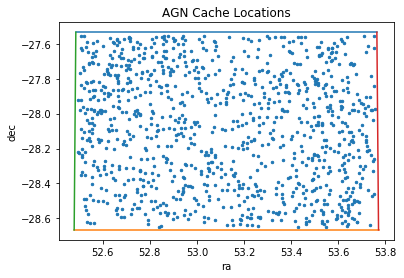

In [23]:
plt.scatter(ra_list, dec_list, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel(r'ra')
plt.ylabel(r'dec')
plt.title('AGN Cache Locations')
#plt.savefig('agn_cache.png')

In [24]:
catalog_row_sort = np.argsort(catalog_row_num)
catalog_row_num = np.array(catalog_row_num)

In [25]:
# Add in Twinkles ID Number to catalog for matched objects
col_list = []
for col in twinkles_lenses.columns:
        col_list.append(fits.Column(name=col.name, format=col.format, array=twinkles_lenses[col.name][catalog_row_num[catalog_row_sort]]))
col_list.append(fits.Column(name='twinklesId', format='I', array=np.arange(len(good_rows))))

Save this catalog of only the systems we need.

In [27]:
cols = fits.ColDefs(col_list)
tbhdu = fits.BinTableHDU.from_columns(cols)
tbhdu.writeto('../../data/cosmoDC2_v1.1.4_matched_AGN.fits')

In [28]:
tbhdu.data[:5]

FITS_rec([ (115074, 0, 2,  0.128,  113.5011,  0.2432515,  153.0029 ,  0.07510341,  122.0065 ,  1.06, -0.1656299 ,  0.1122722 ,  23.19,  23.11888,  0.6968272, [ 0.1132, -0.4384,  0.    ,  0.    ], [-0.0756,  0.3502,  0.    ,  0.    ], [-1.0677,  1.8956,  0.    ,  0.    ], [  2.387,   0.   ,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  471.641754,   600.109436, -20.6982002,  18.3209515,  0.12800001,  1673.38,  1415.12,  0.,   7101.16,  0.,  0.80348599,  0., 'galaxySED/Burst.12E10.04Z.spec',  17.02627634, 0),
          (431864, 0, 2,  0.2  ,  205.1162,  0.2784123,  -39.1588 ,  0.05159786,   75.38537,  2.16,  0.1176923 , -0.06849588,  24.49,  22.90721,  1.882717 , [ 0.8468, -0.8855,  0.    ,  0.    ], [-0.8346, -0.0972,  0.    ,  0.    ], [ 4.2965, -5.3298,  0.    ,  0.    ], [  0.   ,   8.204,   0.   ,   0.   ], [ 0.,  0.,  0.,  0.], [ 0.,  0.,  0.,  0.],  680.579895,   980.035156, -22.3044796,  17.8517303,  0.2       ,  1709.61,  1451.17,  0.,  17071.5 ,  0.,  1.475094

Save the cached `galaxy_id` info to file

In [29]:
agn_cache = pd.DataFrame(np.array([np.array(gal_ids)[catalog_row_sort], np.arange(len(good_rows))], dtype=np.int).T,
                         columns=['galtileid', 'twinkles_system'])

In [30]:
agn_cache.head()

,galtileid,twinkles_system
0,1028678380,0
1,1113068765,1
2,1228448378,2
3,1303476147,3
4,1048007228,4


In [31]:
agn_cache.tail()

,galtileid,twinkles_system
1036,1079462499,1036
1037,1218556515,1037
1038,1105952313,1038
1039,1319006173,1039
1040,1318934270,1040


In [32]:
#Check that galaxy_ids and twinkles_ids in FITS match up after sort
g_id = np.where(np.array(gal_ids) == agn_cache['galtileid'].values[0])
print(np.array(catalog_ids)[g_id] == tbhdu.data['LENSID'][0])

[ True]


In [33]:
agn_cache.to_csv('cosmoDC2_v1.1.4_agn_cache.csv', index=False)

### Match to GLSNe catalog

Here we do the same as we did for the AGN and OM10 catalog except with a bulge+disk galaxy catalog and the host galaxy information from the Gravitationally Lensed SNe catalog.

We begin by loading the hdf5 tables for the lensed SNe catalog into dataframes.

In [68]:
sne_systems = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='system')
sne_images = pd.read_hdf('/global/cscratch1/sd/brycek/glsne_dc2_v2_with_seds.h5', key='image')

In [69]:
use_gals_df = df_galaxy.query('raPhoSim > 52.495 and raPhoSim < 53.755 and decPhoSim > -28.65 and decPhoSim < -27.55')

In [70]:
len(use_gals_df)

1727305

In [78]:
use_gals_df = use_gals_df.merge(df_disk, on='galaxy_id', suffixes=('_bulge', '_disk'))

Following from Table 3 in Mannucci et al. 2005 (https://www.aanda.org/articles/aa/pdf/2005/15/aa1411.pdf) we are going to use galaxy colors
to scale the sn rate by color as a proxy for galaxy type, but we end up changing it from that a bit to give us good sample sizes of all types in the DDF region.

In [79]:
from lsst.utils import getPackageDir

In [80]:
sims_sed_list = os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                        'galaxySED'))

In [81]:
sims_sed_dict = {}
for sed_name in sims_sed_list:
    sed_obj = Sed()
    sed_obj.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'),
                                         'galaxySED', sed_name))
    sims_sed_dict[os.path.join('galaxySED', sed_name)] = sed_obj

In [82]:
# Filters from http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
bp_B = Bandpass(wavelen_max = 2700.)
bp_B.setBandpass(wavelen=np.array([360., 380., 400., 420., 460., 480.,
                                   500., 520., 540., 560.]),
                 sb=np.array([0.00, 0.11, 0.92, 0.94, 0.79, 0.58,
                              0.36, 0.15, 0.04, 0.0]))
bp_K = Bandpass(wavelen_max = 2700.)
bp_K.setBandpass(wavelen=np.linspace(1800., 2600., 17),
                 sb=np.array([0.00, 0.10, 0.48, 0.95, 1.00, 0.98,
                              0.96, 0.95, 0.97, 0.96, 0.94, 0.95,
                              0.95, 0.84, 0.46, 0.08, 0.00]))
bp_dict = BandpassDict(bandpassNameList=['B', 'K'], bandpassList=[bp_B, bp_K])

In [39]:
from lsst.sims.photUtils import getImsimFluxNorm
from copy import deepcopy
bk_color = []
i = 0
for sed_name_bulge, redshift, magNorm_bulge, sed_name_disk, magNorm_disk in zip(use_gals_df['sedFilepath_bulge'].values,
                                                                                use_gals_df['redshift_bulge'].values,
                                                                                use_gals_df['phosimMagNorm_bulge'].values,
                                                                                use_gals_df['sedFilepath_disk'].values,
                                                                                use_gals_df['phosimMagNorm_disk'].values):
    if i % 100000 == 0:
        print(i)

    sed_obj_bulge = deepcopy(sims_sed_dict[sed_name_bulge])
    f_norm_b = getImsimFluxNorm(sed_obj_bulge, magNorm_bulge)
    sed_obj_bulge.multiplyFluxNorm(f_norm_b)
    sed_obj_bulge.redshiftSED(redshift)
    
    sed_obj_disk = deepcopy(sims_sed_dict[sed_name_disk])
    f_norm_d = getImsimFluxNorm(sed_obj_disk, magNorm_disk)
    sed_obj_disk.multiplyFluxNorm(f_norm_d)
    sed_obj_disk.redshiftSED(redshift)
    
    sed_obj = Sed()
    sed_obj.setSED(wavelen=sed_obj_bulge.wavelen, flambda=sed_obj_bulge.flambda+sed_obj_disk.flambda)
    
    
    b_val, k_val = bp_dict.magListForSed(sed_obj)
    bk_color.append(b_val - k_val)
    i+=1

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


In [40]:
bk_color = np.array(bk_color)

In [41]:
# Save so if kernel resets we don't have to do it again.
np.savetxt('bk_color.dat', bk_color)

In [83]:
# Uncomment to load from file
#bk_color = np.genfromtxt('bk_color.dat')

In [85]:
use_gals_df['bk_color'] = bk_color

In [86]:
use_gals_df = use_gals_df.reset_index(drop=True)

As we did before we match based upon a property in each catalog. Here we use the source redshift of the SNe in the lens catalog and the redshift of the potential host galaxies in the uDDF field. Since we have so many potential host galaxies we tighten up the redshift bounds to 0.01 in dex. We also use the galaxy type from the colors to associate to proper types of host galaxies in the lensed SNe catalog.

In [87]:
def find_sne_lens_candidates(galz, gal_type):#, gal_mag):
    # search the galaxy catalog for all possible host galaxies +- 0.05 dex in redshift

    lens_candidates = sne_systems.query(str('zs < {}'.format(np.power(10, np.log10(galz)+0.01)) + ' and ' +
                                            'zs > {}'.format(np.power(10, np.log10(galz)-0.01))))
        
    if gal_type == 't1':
        lens_candidates = lens_candidates.query('host_type == "kinney-starburst"')
    elif gal_type == 't4':
        lens_candidates = lens_candidates.query('host_type == "kinney-elliptical"')
    else:
        lens_candidates = lens_candidates.query('host_type == "kinney-sc"')

    return lens_candidates

In [138]:
#%%time
density_param = .0005
good_rows_sn = []
gal_ids_sn = []
sys_ids_sn = []
used_systems = []
ra_list_sn = []
dec_list_sn = []
type_sn = []
redshift_sn = []

rd_state = np.random.RandomState(47)

for row_idx in range(len(use_gals_df)):
    
    density_test = rd_state.uniform()
    
    gal_bk = use_gals_df['bk_color'].iloc[row_idx]
    
    if gal_bk < 2.6:
        type_density_param = 1.2*density_param
        gal_type = 't1'
    elif ((2.6 <= gal_bk) and (gal_bk < 3.3)):
        type_density_param = 3.*density_param
        gal_type = 't2'
    elif ((3.3 <= gal_bk) and (gal_bk < 4.1)):
        type_density_param = 2.*density_param
        gal_type = 't3'
    else:
        type_density_param = 3.*density_param
        gal_type = 't4'
    
    if density_test > type_density_param:
        continue
    
    row = use_gals_df.iloc[row_idx]
    
    gal_id = use_gals_df['galaxy_id'].iloc[row_idx]
    if gal_id in df_agn['galaxy_id'].values:
        continue
    elif gal_id in sne_avoid_galids:
        continue
    
    if len(good_rows_sn) % 50 == 0:
        print(row_idx, len(good_rows_sn))

    if row.galaxy_id > 0:
        #print(gal_type)
        candidates = find_sne_lens_candidates(row.redshift_bulge, gal_type)
        #print(len(candidates))
        np.random.seed(np.int(row.galaxy_id) % 4294967296)
        keep_idx = []
        for candidate_idx in range(len(candidates)):
            if candidates.index[candidate_idx] in used_systems:
                continue
            else:
                keep_idx.append(candidate_idx)
        candidates = candidates.iloc[keep_idx]

        if len(candidates) > 0:
            choice = np.random.choice(np.arange(len(candidates)), p=candidates['weight']/np.sum(candidates['weight']))
            used_systems.append(candidates.index[choice])
            newlens = candidates.iloc[choice]
            #print(len(catalog_ids))
            sys_ids_sn.append(newlens.sysno)
            gal_ids_sn.append(row.galaxy_id)
            ra_list_sn.append(row.raPhoSim_bulge)
            dec_list_sn.append(row.decPhoSim_bulge)
            good_rows_sn.append(row_idx)
            type_sn.append(gal_type)
            redshift_sn.append(row.redshift_bulge)

11858 0
71585 50
135833 100
207252 150
280622 200


KeyboardInterrupt: 

In [65]:
len(good_rows_sn), len(ra_list_sn)

(845, 845)

In [66]:
print(len(np.where(np.array(type_sn) == "t1")[0]))
print(len(np.where(np.array(type_sn) == "t2")[0]))
print(len(np.where(np.array(type_sn) == "t3")[0]))
print(len(np.where(np.array(type_sn) == "t4")[0]))

587
123
75
60


Once again check to see that we are spread throught uDDF region.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


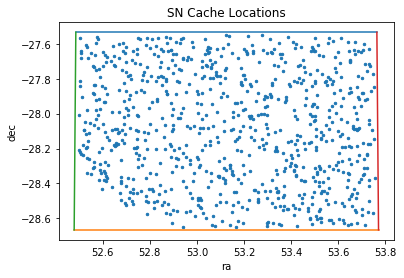

In [67]:
plt.scatter(ra_list_sn, dec_list_sn, s=6)
plt.plot((52.486, 53.764), (-27.533, -27.533))
plt.plot((52.479, 53.771), (-28.667, -28.667))
plt.plot((52.479, 52.486), (-28.667, -27.533))
plt.plot((53.771, 53.764), (-28.667, -27.533))
plt.xlabel('ra')
plt.ylabel('dec')
plt.title('SN Cache Locations')
#plt.savefig('sne_cache.png')

Now we need to join the information in the systems and image dataframes and then save only the ones we are using to file.

In [53]:
keep_systems = sne_systems.iloc[used_systems]

In [54]:
keep_systems['twinkles_sysno'] = np.arange(len(keep_systems)) + 1100

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
keep_catalog = keep_systems.merge(sne_images, on='sysno')

In [56]:
t_start = keep_catalog['t0'] + keep_catalog['td']

In [57]:
keep_catalog['t_start'] = t_start

In [58]:
keep_catalog.to_csv('cosmoDC2_v1.1.4_sne_cat.csv', index=False)

Save the cache of `galaxy_ids` and associated `twinklesId` values to file.

In [59]:
sne_cache = pd.DataFrame(np.array([gal_ids_sn, np.arange(len(keep_systems)) + 1100], dtype=np.int).T, columns=['galtileid', 'twinkles_system'])

In [60]:
sne_cache.to_csv('cosmoDC2_v1.1.4_sne_cache.csv', index=False)

### Check that `galaxy_ids` will not clash when the sprinkler modifies them

We need to make sure that we can adjust the `galaxy_id` values of the sprinkler galaxies so that we can record information in the id values, but we need to make sure the new id values don't clash with `cosmoDC2` id values. We check that below.

In [261]:
import GCRCatalogs
import pandas as pd
from GCR import GCRQuery

In [262]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [265]:
cosmo_ids = catalog.get_quantities(['galaxy_id'])

In [286]:
smallest_id = np.min(cosmo_ids['galaxy_id'])
largest_id = np.max(cosmo_ids['galaxy_id'])

In [287]:
print(largest_id, smallest_id)

14345538432 1000000000


The highest `galaxy_id` in `cosmoDC2_v1.0_image` is ~1.44e10. Therefore, if we add 1.5e10 to all `galaxy_id` values that are sprinkled then we will be above this. After that we multiply by 10000 to get room to add in the twinkles system numbers in the last 4 digits. If these numbers are less that 2^63 then we will be ok when generating instance catalogs.

In [298]:
offset = np.int(1.5e10)

In [304]:
(2**63) - np.left_shift((largest_id + offset)*10000, 10)

8.9228737233110958e+18

We are under the 2^63 limit. So, we can use this scheme to make sure there are no id clashes and add in the twinkles information as before.